# How to handle data recordings?


Author: Sadique Sheik, SynSense Zurich

## Event/Spike/AER data management



In this tutorial, we will go through the various steps involved in handling data from DVS sensors such that it is usable with deep-learning frameworks such as `pytorch` or `sinabs`.



<img src="../_static/dv.png" alt="Event Sensor UI" style="width: 800px;" align=center/>


## Challenge
Traditional deep-learning(DL) frameworks for vision processing operate on images/frames whereas data generated by neuromprphic sensors is a sequence of events. 

<img src="../_static/spikes_vs_frames.png" alt="Event Streams vs Video Frames" style="width: 800px;" align="center"/>

1. The data produced is recorded in **custom datatypes** which are not directly supported by dataloaders.

2. The **event/spike streams** are **not images/frames** and cannot be directly used to train or test DL models.


These differences render event data in its native form incompatible with DL platforms.

## Solutions


1. Event driven simulators specifically designed for SNNs.
2. Convert events to frame based data and use standart DL libraries.
3. Hybrid approach: Use a combination of both to get the best of both worlds.

## Hybrid approach (Train on frames, Run on SNNs)

In this notebook we will mostly focus on this approach. This gives us the following advantages.

    - Fast training (like PyTorch or Tensorflow)
    - Low power inference on Neuromorphic ASICs. (like DYNAP-CNN)
    

## N-MNIST Dataset preprocessing

As a walk through example, we will load data from the N-MNIST dataset. 

1. We will first start by downloading the raw data from dropbox. 
2. Then we will use `aermanager` to pre-process this data and create a dataset suitable for training and testing and save it to a hdf5 database.
3. Finally we will load this data as a `Dataset` and visualize it. 

## 1. Download NMIST dataset

In [1]:
import pathlib
import urllib

# To keep this notebook clean, we will suppress all warnings.
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Create a folder to download the data
path = pathlib.Path("./data/N-MNIST/")
path.mkdir(parents=True, exist_ok=True)

In [ ]:
if not (path/"Test.zip").exists():
    # Download test set
    urllib.request.urlretrieve("https://www.dropbox.com/sh/tg2ljlbmtzygrag/AADSKgJ2CjaBWh75HnTNZyhca/Test.zip?dl=1", path / "Test.zip")

In [ ]:
if not (path/"Train.zip").exists():
    # Download training set
    urllib.request.urlretrieve("https://www.dropbox.com/sh/tg2ljlbmtzygrag/AABlMOuR15ugeOxMCX0Pvoxga/Train.zip?dl=1", path / "Train.zip")

In [3]:
ls "./data/N-MNIST/"

Test/  Test.zip  Train/  Train.zip


### Unzip downloaded data

The downloaded data is in two files, `Test.zip` and `Trian.zip`. We extract this data into corresponding subfolders.

In [ ]:
# Unzip data
import zipfile
with zipfile.ZipFile(path/"Test.zip", 'r') as f:
    f.extractall(path)
    
with zipfile.ZipFile(path/"Train.zip", 'r') as f:
    f.extractall(path)

### Load data for visualization

Let us now load a datasample from the downloaded data. We will parse a file into a numpy array of events.

We can use `aermanager` to load the file and extract data into a convenient data format. In particular, we will need a parser that is specifically designed to parse data in the N-MNIST dataset: `parse_nmnist`.

In [4]:
from aermanager.aerparser import load_events_from_file
from aermanager.parsers import parse_nmnist

shape, xytp = load_events_from_file(path/"Test/0/00004.bin", parser=parse_nmnist)

Let us have a quick look at the first few events in `xytp`. You will see that `xytp` is a structured numpy array with columns `x`, `y`, `t` and `p` (corresponding to the width, height, spike time and polarity of each event).

In [5]:
xytp[:5]

array([(18, 11,  581, False), (21, 13, 1703, False),
       (12, 24, 2625, False), (21, 13, 4358, False),
       (28, 18, 4838,  True)],
      dtype=[('x', '<u2'), ('y', '<u2'), ('t', '<u8'), ('p', '?')])

Let us visualize the event stream as an image where the value at each pixel in the 2D image holds the number of events produced by that pixel. We can use the method `accumulate_frames` to do this.

In [6]:
from aermanager.preprocess import accumulate_frames
frames = accumulate_frames([xytp], range(shape[0]+1), range(shape[1]+1))

In [7]:
frames[0].shape

(2, 34, 34)

As can be seen above, the frame produced has dimensions of 3: (polarity, height, width). We can use this data to visualize our events in matplotlib.

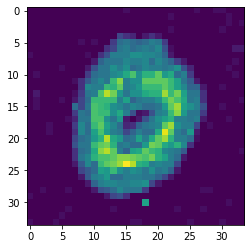

In [8]:
import matplotlib.pyplot as plt
plt.imshow(frames[0].sum(0))

The above blurry image show us that this was a recording of the digit `0`. We can check the time length of this recording.

In [9]:
t_window = xytp['t'][-1] - xytp['t'][0]
print(f"The data sample was recorded for {t_window/1e6} s")

The data sample was recorded for 0.307948 s


## 2. Generate Pre-processed dataset for training and testing

The previous figure shows a blurry image that was generated by accumulating all the events within the recording. But inpractice, one can imagine that this data is actually acquired from a moving digit `0` over a given time window. In order to visualize this data we will have to create images that consitite of events from smaller time window.

There are a few different ways of accomplishing this:

1. Split the data into equal time length windows
2. Split the data by equal spike counts



For this example we will split the data into smaller time bins with each bin comprising a fixed **number of spikes**. 300 spikes seems like a reasonable number of spikes in this dataset (for a reasonable visualization).

In [10]:
import numpy as np
from aermanager.preprocess import slice_by_count

indices = slice_by_count(xytp=xytp, spike_count=1000)
sliced_xytp = np.split(xytp, indices)
sliced_frames = accumulate_frames(sliced_xytp, range(shape[0]+1), range(shape[1]+1))

Now let us visualize these frames

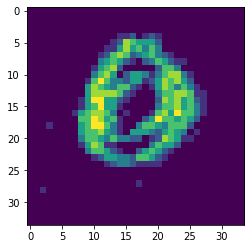

In [11]:
plt.imshow(sliced_frames[4].sum(0))

If you are running this notebook, you can use the below code snippet to visualize all the images in the generated dataset interactively.

In [12]:
from ipywidgets import interact
@interact
def show_frame(x=(0, len(sliced_frames)-1, 1)):
    plt.imshow(sliced_frames[x].sum(0))

interactive(children=(IntSlider(value=2, description='x', max=5), Output()), _dom_classes=('widget-interact',)…

You can see that this data is much more crip than what was shown in the previous plot. Such sharp data is ideal to be able to train a DL model.

In order to do so, 
1. We can pre-process the data from the downloaded files as seen above.
2. Save them as a new dataset to be used for training.

For a large number of files, there is a convenient way to pre-process and save them into one consistent dataset for use later. You can do so by using `gen_dataset_from_folders` method.
We will use this method to first create a dataset of all `test` samples from the `N-MNIST` `.bin` files.

In [ ]:
from aermanager.dataset_generator import gen_dataset_from_folders
gen_dataset_from_folders(
    source_path=path/"Test", 
    destination_path="./dataset300/N-MNIST/Test/",
    pattern="*.bin", # File extension of N-MNIST recording files
    spike_count=300,
    parser=parse_nmnist,
)

## 3. Load the generated dataset

Once the raw recordings are converted into a convenient set of smaller recordings we can load this data as a iterable `Dataset` as follows.

    NOTE: While in principle you could have done all this pre-processing on the fly, it could be an extrememly slow process and can result in a bottle-neck while loading batch data for training.

In [13]:
from aermanager.datasets import FramesDataset
test_dataset = FramesDataset(source_folder="./dataset300/N-MNIST/Test/")

The data can be accessed for the dataset by simple indexing and can therefore be used to instantiate intricate `Dataloader`s like those available in `PyTorch`

In [14]:
img, label = test_dataset[0]

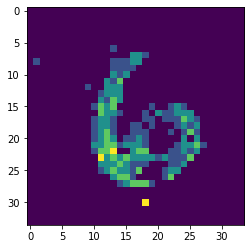

In [15]:
# Display one of the frames from the generated dataset
img, label = test_dataset[1238]
plt.imshow(img.sum(0))

If you are running this notebook, you can use the below code snippet to visualize all the images in the generated dataset interactively.

In [16]:
from ipywidgets import interact
@interact
def show_sample(x=(0, len(test_dataset)-1, 5)):
    img, label = test_dataset[x]
    plt.imshow(img.sum(0))

interactive(children=(IntSlider(value=67560, description='x', max=135122, step=5), Output()), _dom_classes=('w…

We can repeat the same exercise for the training dataset.

In [ ]:
from aermanager.dataset_generator import gen_dataset_from_folders
gen_dataset_from_folders(
    source_path=path/"Train/", 
    destination_path="./dataset/N-MNIST/Train/",
    pattern="*.bin", # File extension of N-MNIST recording files
    spike_count=1000,
    parser=parse_nmnist,
)

## Loading spikes instead of frames

In the above snippets we saw how to load frames, which we could use for training and testing ANNs. But when we simulate spiking neural networks, we will ideally want to use spike events, not the frames.

For this instead of using a `FramesDataset` we will now use `SpikeTrainDataset` and point it to the same pre-processed data location.

In [17]:
from aermanager.datasets import SpikeTrainDataset
test_dataset_spiking = SpikeTrainDataset(source_folder="./dataset300/N-MNIST/Test/")

Similar to the `FrameDataset`, the `SpikeTrainDataset` is also an iterable and can be indexed similarly.

In [18]:
xytp, label = test_dataset_spiking[0]
xytp[:5]

array([( 7,  7, 5087,  True), (19, 13, 6544,  True),
       (15, 10, 7283, False), (14, 21, 7500,  True),
       (16, 18, 7736,  True)],
      dtype=[('x', '<u2'), ('y', '<u2'), ('t', '<u8'), ('p', '?')])

It is often useful to get `xytp` as a spike raster ie. a tensor with 0 where there is no spike and 1 when there is a spike. This is expecially useful when using with `sinabs` or other DL libraries as you will see later.

In order to get spike rasters instead of spike trains we need to provide a time bin `dt` while initializing the dataset.

In [19]:
test_dataset_dt = SpikeTrainDataset(source_folder="./dataset300/N-MNIST/Test/", dt=1000)

In [20]:
data, label = test_dataset_dt[0]

In [21]:
data.shape

(29, 2, 34, 34)

The shape of the resultant spike raster is (time, polarity, height, width)

## Conclusion

I hope this gives you a good overview of the tooling available to be able to work with spikes recorded from DVS sensors and how you can pre-process them using some convenience methods provided by `aermanager`.